In [1]:
import cv2
import numpy as np
from feature_matching import match_pairs, load_image, detect_and_compute, match_features
import glob

In [2]:
import numpy as np
img = cv2.imread("./data/bookshelf_corner/img_005.jpeg")
img_height, img_width = img.shape[:2]

sensor_diagonal_mm = 9.2  

sensor_width_mm  = sensor_diagonal_mm * 4/5   
sensor_height_mm = sensor_diagonal_mm * 3/5 

equiv_focal_mm = 27.0     
full_frame_diag = 43.27    

physical_f_mm = equiv_focal_mm * (sensor_diagonal_mm / full_frame_diag)

fx = (physical_f_mm / sensor_width_mm) * img_width
fy = (physical_f_mm / sensor_height_mm) * img_height

cx = img_width  / 2
cy = img_height / 2

K = np.array([
    [fx, 0,  cx],
    [0,  fy, cy],
    [0,   0,  1]
])

print("Physical focal length (mm):", physical_f_mm)
print("\nIntrinsic matrix K:\n", K)

Physical focal length (mm): 5.740697943147676

Intrinsic matrix K:
 [[1.24797781e+03 0.00000000e+00 8.00000000e+02]
 [0.00000000e+00 1.24797781e+03 6.00000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [3]:
image_paths = sorted(glob.glob("data/bookshelf_corner/*.jpeg"))

img1_color, img1_gray = load_image(image_paths[0])
img2_color, img2_gray = load_image(image_paths[1])

kp1, des1, norm = detect_and_compute(img1_gray)
kp2, des2, _ = detect_and_compute(img2_gray)

matches = match_features(des1, des2, norm)

match_qidx = [m.queryIdx for m in matches]   
match_tidx = [m.trainIdx for m in matches]  

pts1 = np.float32([kp1[i].pt for i in match_qidx])
pts2 = np.float32([kp2[i].pt for i in match_tidx])

E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
inliers1 = pts1[mask.ravel() == 1]
inliers2 = pts2[mask.ravel() == 1]

_, R, t, mask_pose = cv2.recoverPose(E, inliers1, inliers2, K)
R_prev, t_prev = R, t
kp_prev, des_prev = kp2, des2    

camera_1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
camera_2 = K @ np.hstack((R, t))

points_4D = cv2.triangulatePoints(camera_1, camera_2, inliers1.T, inliers2.T)
triangulated_points_3D = (points_4D[:3] / points_4D[3]).T 
print(triangulated_points_3D.shape)

map_points_3d = triangulated_points_3D.copy()

(770, 3)


In [4]:
z_cam1 = triangulated_points_3D[:, 2]

z_cam2 = (R @ triangulated_points_3D.T + t).T[:, 2]

mask_ = (z_cam1 > 0) & (z_cam2 > 0)
triangulated_points_3D = triangulated_points_3D[mask_]
print(triangulated_points_3D.shape)

(770, 3)


In [5]:
class Point3D_with_views:
    def __init__(self, point3d):
        self.point3d = point3d     
        self.source_2dpt_idxs = {}  

In [6]:
map_points = []
map_points_obj = []
all_keypoints = []
all_keypoints.append(kp1)
all_keypoints.append(kp_prev)

inlier_qidx  = [match_qidx[i] for i in range(len(match_qidx)) if mask.ravel()[i] == 1]
inlier_tidx  = [match_tidx[i] for i in range(len(match_tidx)) if mask.ravel()[i] == 1]
inlier_qidx = np.array(inlier_qidx)[mask_]
inlier_tidx = np.array(inlier_tidx)[mask_]
inliers1 = inliers1[mask_]
inliers2 = inliers2[mask_]

camera_poses = {}

camera_poses[0] = (np.eye(3), np.zeros((3,1)))
camera_poses[1] = (R, t) 

for k in range(len(triangulated_points_3D)):
    map_points.append({
        "point_3d": triangulated_points_3D[k],
        "descriptor": des1[inlier_qidx[k]],
        "kp": kp1[inlier_qidx[k]].pt
    })

matches = np.array(matches)                          
E_mask = mask.ravel().astype(bool)                  
matches_E = matches[E_mask]                        
good_matches = matches_E[mask_]                      

for idx, P in enumerate(triangulated_points_3D):
    match = good_matches[idx]
    pt_obj = Point3D_with_views(P)
    pt_obj.source_2dpt_idxs[0] = match.queryIdx  
    pt_obj.source_2dpt_idxs[1]   = match.trainIdx 
    map_points_obj.append(pt_obj)


for i in range(2, len(image_paths)):   
    print(f"\nProcessing image {i+1}/{len(image_paths)}")

    img_color, img_gray = load_image(image_paths[i])
    kp_i, des_i, _ = detect_and_compute(img_gray)

    map_des = np.array([mp["descriptor"] for mp in map_points])
    map_3d  = np.array([mp["point_3d"] for mp in map_points])

    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches_2d3d = match_features(des_i, map_des, cv2.NORM_L2)

    pts2d = np.float32([kp_i[m.queryIdx].pt for m in matches_2d3d])
    pts3d = np.float32([map_3d[m.trainIdx] for m in matches_2d3d])

    _, rvec, tvec, inliers = cv2.solvePnPRansac(
        pts3d, pts2d, K, None,
        reprojectionError=8.0,
        confidence=0.999
    )
    R_i, _ = cv2.Rodrigues(rvec)
    t_i = tvec
    camera_poses[i] = (R_i, t_i) 
    all_keypoints.append(kp_i)
    if inliers is None:
        print(f"Image {i}: PnP failed (no inliers)")
        continue
    else:
        print(f"Image {i}: Pose estimated with {len(inliers)} inliers")

    matches_prev = bf.knnMatch(des_prev, des_i, k=2)
    good = []
    for m,n in matches_prev:
        if m.distance < 0.75*n.distance:
            good.append(m)
    pts_prev = np.float32([kp_prev[m.queryIdx].pt for m in good])
    pts_curr = np.float32([kp_i[m.trainIdx].pt for m in good])

    P_prev = K @ np.hstack((R_prev, t_prev))
    P_curr = K @ np.hstack((R_i, t_i))

    points4D = cv2.triangulatePoints(P_prev, P_curr, pts_prev.T, pts_curr.T)
    points3D = (points4D[:3] / points4D[3]).T

    z_prev = points3D[:, 2]
    z_curr = (R_i @ points3D.T + t_i).T[:, 2]
    mask_z = (z_prev > 0) & (z_curr > 0)

    points3D = points3D[mask_z]
    pts_curr = pts_curr[mask_z]
    
    good = np.array(good)[mask_z]
    
    for idx, P in enumerate(points3D):
        match = good[idx]   
        mp_descriptor = des_i[match.trainIdx]
        mp_keypoint  = kp_i[match.trainIdx].pt

        map_points.append({
            "point_3d": P,
            "descriptor": mp_descriptor,
            "kp": mp_keypoint
        })
        pt_obj = Point3D_with_views(P)
        pt_obj.source_2dpt_idxs[i-1] = match.queryIdx 
        pt_obj.source_2dpt_idxs[i]   = match.trainIdx  
        map_points_obj.append(pt_obj)

    print(f"Added {len(points3D)} new 3D points to map.")
    R_prev, t_prev = R_i, t_i
    kp_prev, des_prev = kp_i, des_i
    



Processing image 3/11
Image 2: Pose estimated with 162 inliers
Added 484 new 3D points to map.

Processing image 4/11
Image 3: Pose estimated with 204 inliers
Added 1706 new 3D points to map.

Processing image 5/11
Image 4: Pose estimated with 421 inliers
Added 397 new 3D points to map.

Processing image 6/11
Image 5: Pose estimated with 396 inliers
Added 1018 new 3D points to map.

Processing image 7/11
Image 6: Pose estimated with 331 inliers
Added 246 new 3D points to map.

Processing image 8/11
Image 7: Pose estimated with 94 inliers
Added 96 new 3D points to map.

Processing image 9/11
Image 8: Pose estimated with 159 inliers
Added 1229 new 3D points to map.

Processing image 10/11
Image 9: Pose estimated with 357 inliers
Added 678 new 3D points to map.

Processing image 11/11
Image 10: Pose estimated with 497 inliers
Added 309 new 3D points to map.


In [7]:
R_mats = {i: camera_poses[i][0] for i in camera_poses}
t_vecs = {i: camera_poses[i][1] for i in camera_poses}
resected_imgs = list(range(len(all_keypoints)))

Using this code for BA: https://github.com/rshilliday/sfm/blob/master/bundle_adjustment.py

In [8]:
from bundle_adjustment import do_BA 

map_points_after_adjustment, R_mats, t_vecs = do_BA(
    points3d_with_views=map_points_obj,
    R_mats=R_mats,
    t_vecs=t_vecs,
    resected_imgs=resected_imgs,
    keypoints=all_keypoints,
    K=K,
    ftol=1e-6
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.5127e+08                                    2.72e+10    
       1              3         1.4099e+08      3.10e+08       2.45e+03       3.79e+09    
       2              5         8.8378e+07      5.26e+07       2.35e+01       2.01e+09    
       3              7         7.1463e+07      1.69e+07       9.55e+00       1.48e+09    
       4              8         4.9421e+07      2.20e+07       1.34e+01       7.96e+08    
       5             11         4.7401e+07      2.02e+06       1.82e+00       7.39e+08    
       6             12         4.3754e+07      3.65e+06       2.84e+00       6.36e+08    
       7             15         4.3331e+07      4.23e+05       3.59e-01       6.24e+08    
       8             18         4.3279e+07      5.24e+04       4.46e-02       6.23e+08    
       9             22         4.3277e+07      1.64e+03       1.39e-03       6.23e+08    

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def compute_reprojection_errors(map_points, R_mats, t_vecs, all_keypoints, K):
    errors = []

    for mp in map_points:
        X = mp.point3d.reshape(3, 1)

        for cam_idx, kp_idx in mp.source_2dpt_idxs.items():
            R = R_mats[cam_idx]
            t = t_vecs[cam_idx]

            P = K @ np.hstack([R, t])
            X_h = np.vstack([X, 1])
            proj = P @ X_h
            proj = proj[:2] / proj[2]

            kp = np.array(all_keypoints[cam_idx][kp_idx].pt)

            err = np.linalg.norm(proj.flatten() - kp)
            errors.append(err)

    return np.array(errors)

In [10]:
reprojection_errors = compute_reprojection_errors(
    map_points_after_adjustment,
    R_mats,
    t_vecs,
    all_keypoints,
    K
)

print("Mean reprojection error:", np.mean(reprojection_errors))
print("Max reprojection error:", np.max(reprojection_errors))

Mean reprojection error: 89.49014709529584
Max reprojection error: 6112.886598969958


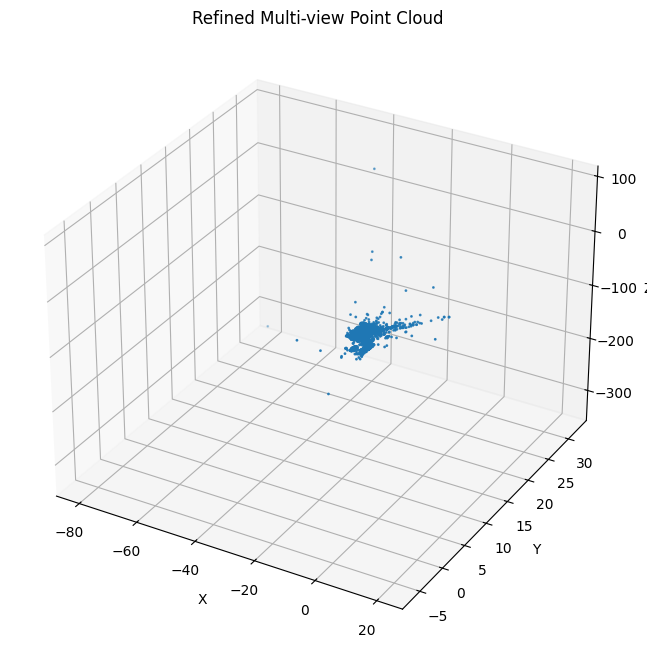

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

points = np.array([mp.point3d for mp in map_points_after_adjustment])
points = points.squeeze()  
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Refined Multi-view Point Cloud")

plt.show()

X range: -80.62476799859138 20.853972136831125
Y range: -6.0115967627677955 31.83792740835053
Z range: -328.0669036111569 88.07093563607849


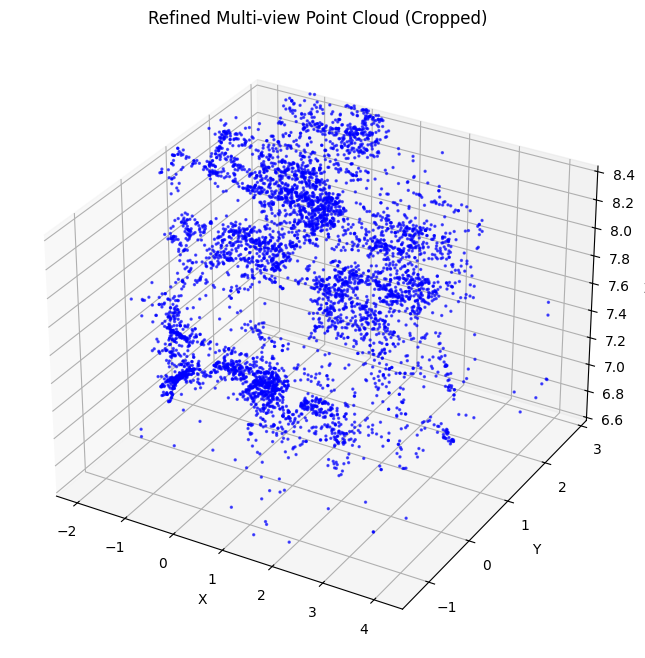

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

points = np.array([mp.point3d for mp in map_points_after_adjustment])
points = points.reshape(-1, 3)  

print("X range:", points[:,0].min(), points[:,0].max())
print("Y range:", points[:,1].min(), points[:,1].max())
print("Z range:", points[:,2].min(), points[:,2].max())

x_min, x_max = np.percentile(points[:,0], [5, 95])
y_min, y_max = np.percentile(points[:,1], [5, 95])
z_min, z_max = np.percentile(points[:,2], [5, 95])

mask = (
    (points[:,0] >= x_min) & (points[:,0] <= x_max) &
    (points[:,1] >= y_min) & (points[:,1] <= y_max) &
    (points[:,2] >= z_min) & (points[:,2] <= z_max)
)
points_cropped = points[mask]

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points_cropped[:,0], points_cropped[:,1], points_cropped[:,2], s=2, c='blue', alpha=0.6)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Refined Multi-view Point Cloud (Cropped)")

plt.show()